In [22]:
from pathlib import Path
import sys

yolo_dir = Path.home()/'new_yolov5/yolov5'
if yolo_dir.is_dir():
    sys.path.append(str(yolo_dir))



from utils.tools.general import *
import utils.tools.file as fu
import utils.tools.image as iu
import boxx
from typing import List


# utils

In [16]:
def img_info(img):
    print('type:', type(img))
    print(f"img.shape:  {img.shape}")


# def show_bb(img, labels, size=3):
#     bbs = iu.get_bbs(img.shape, labels, has_cls_id=True)
#     iu.show_bb(img, bbs, size)

def dash(n=100):
	print('-'*n)

    ## GridMsg

In [6]:

import pandas as pd
from IPython.core.display import HTML, display

class GridMsg:
    def __init__(self, header: str=None):
        self.header = header
        self.msg = []
        self.content = []
    
    def set_max_width(self, max_colwidth):
        pd.set_option('display.max_colwidth', max_colwidth)

    def reset_max_width(self):
        pd.reset_option('display.max_colwidth')
    
    def copy_content(self, content):
        if isinstance(content, np.ndarray):
            return content.copy()
        
        elif torch.is_tensor(content):
            return content.clone()

        else:
            return content

    def add(self, msg:str, content, copy=True):
        content = str(self.copy_content(content) if copy else content)
        self.msg.append(str(msg))
        self.content.append(content)
        return self

    def add_dict(self, dict_):
        {self.add(k,v) for k,v in dict_.items()}
        return self


    def set_df_style(self):
        dfStyler = self.df.style.set_properties(**{
            'text-align': 'left',
            'white-space': 'pre-wrap'
        })
        self.styled_df = dfStyler.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

    def set_caption(self, color='white', padding="5px"):
        '''color cant be None'''
        styles = [
            dict(selector="caption",
                props=[("text-align", "center"), ("font-size", "120%"), ("padding", padding),
                        ("color", color)])
        ]

        self.styled_df = self.styled_df.set_caption(self.header).set_table_styles(styles)

    def create_df(self):
        index = [0] if len(self.content) == 1 else range(len(self.content)) # handle scalar record
        self.df = pd.DataFrame({'msg': self.msg, 'content': self.content}, index=index)

    def show(self, max_width=200):
        self.create_df()
        self.set_df_style()
        self.set_caption()
        self.set_max_width(max_width)
        display(self.styled_df)
        self.reset_max_width()
        

In [7]:

# n = 8
# boxx.show([img for img, bbox in paste_train.gen_back_img(n)])

# demo paste in class

In [9]:
%load_ext autoreload
%autoreload
from utils.datasets import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def img_out_2_showable(img_out):
    '''output should be numpy.ndarray uint8 (HxWxC, RGB)'''
    return img_out.permute(1, 2, 0).numpy().astype('uint8')

def labels_2_plotable(labels_out, img_out):
    img = img_out_2_showable(img_out)
    h, w, _ = img.shape

    confidence, cls_id, xywh_labels = labels_out[:, 0] , labels_out[:, 1], labels_out[:, 2:6]
    xyxy = xywhn2xyxy(xywh_labels, w, h)
    labels_xyxy = torch.cat([cls_id.unsqueeze(1), xyxy], 1).numpy()
    return labels_xyxy

# im_to_plot = img_out_2_showable(torch_img)
# labels_xyxy = labels_2_plotable(labels_out, torch_img)
# show_bb(im_to_plot, labels_xyxy)

# load args

In [47]:
mosaic = False
# back_img_path = '../datasets/coco128/images/train2017'
# back_img_path = '../datasets/test_background/images'   # test img without putting any labels
# back_img_path = yolo_dir/'utils/paster/examples/fake_coco_128'
dpath = Path('/mnt/disks/datasets')
# back_img_path = train_dpath = dpath/'coco2017/train2017'

yaml_dir = yolo_dir/'data'/'test_sampled_coco2017'
back_img_path = (yaml_dir/'train_images.txt')

def get_load_args(back_img_path, mosaic=False, augment=True):

    load_args = {'augment': True,
        'path': back_img_path,
        'batch_size': 8,
        'cache_images': None,
        'hyp': {'anchor_t': 4.0,
                'box': 0.05,
                'cls': 0.5,
                'cls_pw': 1.0,
                'copy_paste': 0.0,
                'degrees': 0.0,
                'fl_gamma': 0.0,
                'fliplr': 0.5,
                'flipud': 0.0,
                'hsv_h': 0.015,
                'hsv_s': 0.7,
                'hsv_v': 0.4,
                'iou_t': 0.2,
                'lr0': 0.01,
                'lrf': 0.2,
                'mixup': 0.0,
                'momentum': 0.937,
                'mosaic': 1.0 if mosaic else 0,
                'obj': 1.0,
                'obj_pw': 1.0,
                'perspective': 0.0,
                'scale': 0.5,
                'shear': 0.0,
                'translate': 0.1,
                'warmup_bias_lr': 0.1,
                'warmup_epochs': 3.0,
                'warmup_momentum': 0.8,
                'weight_decay': 0.0005},
        'image_weights': False,
        'img_size': 640,
        'pad': 0.0,
        'prefix': '\x1b[34m\x1b[1mtrain: \x1b[0m',
        'rect': False,
        'single_cls': False,
        'stride': 32}
    return load_args

# test paste after new weighted

In [24]:
%load_ext autoreload
%autoreload
from utils.datasets import *
import utils.tools.image as iu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
back_img_path = (yaml_dir/'train_images.txt')
train_loader = LoadImagesAndLabels(**get_load_args(back_img_path))
torch_img, labels_out, img_file, shapes = train_loader[6]

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
 angles list: ['tb45' 't45' 't90' 'hb45' 'tb90' 'h45']
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


train: Scanning '/home/cheeyung/new_yolov5/yolov5/data/test_sampled_coco2017/train_images.cache' images and labels... 120 found, 0 missing, 18 empty, 0 corrupted: 100%|██████████| 120/120 [00:00<?, ?it/s]


In [49]:
back_img_path = (yaml_dir/'val_images.txt')
val_loader = LoadImagesAndLabels(**get_load_args(back_img_path))
torch_img, labels_out, img_file, shapes = train_loader[6]

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
 angles list: ['tb45' 't45' 't90' 'hb45' 'tb90' 'h45']
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


train: Scanning '/home/cheeyung/new_yolov5/yolov5/data/test_sampled_coco2017/val_images' images and labels...40 found, 0 missing, 0 empty, 0 corrupted: 100%|██████████| 40/40 [00:00<00:00, 862.22it/s]


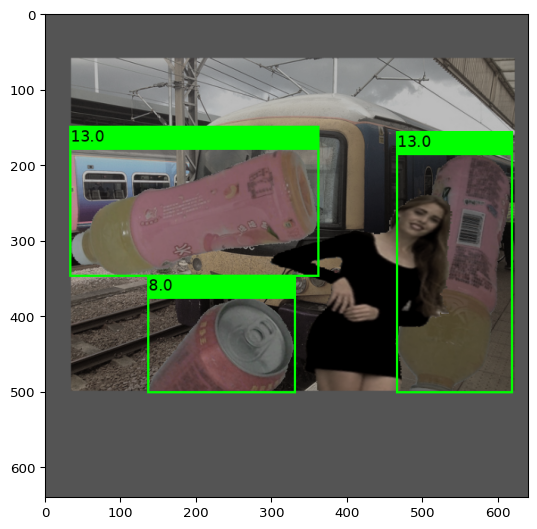

In [50]:
im_to_plot = img_out_2_showable(torch_img)
labels_xyxy = labels_2_plotable(labels_out, torch_img)
iu.show_bb(im_to_plot, labels_xyxy, has_cls_id=True, size=3)

In [51]:
def next_batch(n, loader, show=False):
    im_to_plot_s = []
    labels_xyxys = []
    for i in range(n):
        idx = np.random.randint(0, len(loader))
        torch_img, labels_out, img_file, shapes = loader[idx]
        # torch_img, labels_out, img_file, shapes = loader[6]
        im_to_plot = img_out_2_showable(torch_img)
        labels_xyxy = labels_2_plotable(labels_out, torch_img)
        im_to_plot_s.append(im_to_plot)
        labels_xyxys.append(labels_xyxy)

    if show:
        boxx.show([iu.draw_bb(img, label, has_cls_id=True) for img, label in zip(im_to_plot_s, labels_xyxys)]
         ,figsize=(15,15))

train


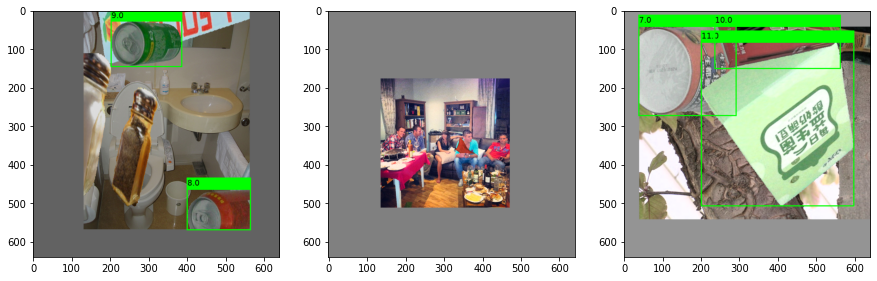

--------------------------------------------------
val


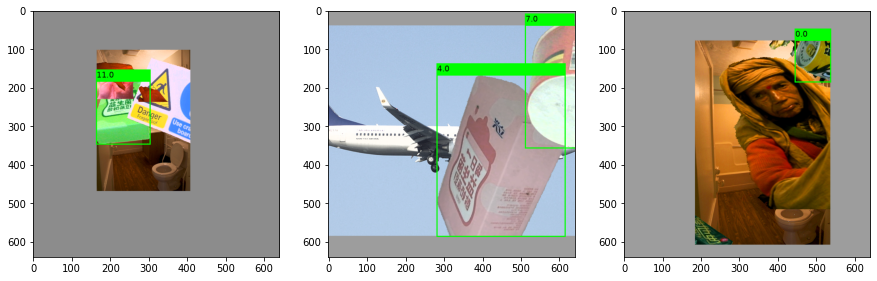

In [55]:
# for i in tqdm(range(2)):
print('train')
next_batch(3, train_loader, show=True)
dash()
print('val')
next_batch(3, val_loader, show=True)

# for i in tqdm(range(128)):
#     next_batch(3)

In [19]:
# sample_n = 100
# for i in tqdm(range(sample_n)):
#     next_batch(1)


# test save with utils/gen_datasets.py

In [17]:

from utils.paster.create_datasets import LoadProductWithNoise
mixed_coco = LoadProductWithNoise()

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
 angles list: ['tb45' 't45' 't90' 'hb45' 'tb90' 'h45']
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [42]:
%autoreload
from utils.gen_datasets import GenImageWithLoader

In [65]:
mosaic = False
# back_img_path = '../datasets/coco128/images/train2017'
# back_img_path = '../datasets/test_background/images'   # test img without putting any labels
# back_img_path = yolo_dir/'utils/paster/examples/fake_coco_128'
back_img_dpath = Path.home()/'datasets_bp/coco128/images/train2017'
bimg_paths = pd.Series(back_img_dpath.ls('*.jpg'))
root_save_dir = Path('temp_test_save')
# nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, workers])

load_args = {
    "root_save_dir":  root_save_dir,
    "mixed_coco":  mixed_coco,
    "bimg_paths":  bimg_paths,

    'augment': True,
    'batch_size': 8,
    'cache_images': None,
    'hyp': {'anchor_t': 4.0,
            'box': 0.05,
            'cls': 0.5,
            'cls_pw': 1.0,
            'copy_paste': 0.0,
            'degrees': 0.0,
            'fl_gamma': 0.0,
            'fliplr': 0.5,
            'flipud': 0.0,
            'hsv_h': 0.015,
            'hsv_s': 0.7,
            'hsv_v': 0.4,
            'iou_t': 0.2,
            'lr0': 0.01,
            'lrf': 0.2,
            'mixup': 0.0,
            'momentum': 0.937,
            'mosaic': 1.0 if mosaic else 0,
            'obj': 1.0,
            'obj_pw': 1.0,
            'perspective': 0.0,
            'scale': 0.5,
            'shear': 0.0,
            'translate': 0.1,
            'warmup_bias_lr': 0.1,
            'warmup_epochs': 3.0,
            'warmup_momentum': 0.8,
            'weight_decay': 0.0005},
    'image_weights': False,
    'img_size': 640,
    'pad': 0.0,
    # 'path': '../datasets/coco128/images/train2017',
    'path': back_img_path,
    'prefix': '\x1b[34m\x1b[1mtrain: \x1b[0m',
    'rect': False,
    'single_cls': False,
    'stride': 32}

In [80]:


def create_dataloader(batch_size=4, workers=4, rank=-1, image_weights=None, quad=False):
    # Make sure only the first process in DDP process the dataset first, and the following others can use the cache
    with torch_distributed_zero_first(rank):
        dataset = GenImageWithLoader(**load_args)
        

    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, workers])  # number of workers
    sampler = torch.utils.data.distributed.DistributedSampler(dataset) if rank != -1 else None
    loader = torch.utils.data.DataLoader if image_weights else InfiniteDataLoader
    # Use torch.utils.data.DataLoader() if dataset.properties will update during training else InfiniteDataLoader()
    dataloader = loader(dataset,
                        batch_size=batch_size,
                        num_workers=nw,
                        sampler=sampler,
                        pin_memory=True,
                        collate_fn=lambda x: [np.zeros((0,5)), True])
    return dataloader, dataset

# gen_loader = GenImageWithLoader(**load_args)
gen_loader = create_dataloader()

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
 angles list: ['tb45' 't45' 't90' 'hb45' 'tb90' 'h45']
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


train: Scanning '/home/cheeyung/new_yolov5/yolov5/utils/paster/examples/fake_coco_128/labels.cache' images and labels... 127 found, 0 missing, 31 empty, 0 corrupted: 100%|██████████| 127/127 [00:00<?, ?it/s]


In [81]:
next(iter(gen_loader))

In [84]:
dataloader_iterator = iter(gen_loader)
for i in range(10):
    try:
        data, target = next(dataloader_iterator)
    except StopIteration:
        dataloader_iterator = iter(gen_loader)
        # data, target = next(dataloader_iterator)
    # do_something()

ValueError: too many values to unpack (expected 2)

In [ ]:
for i in tqdm(range(10)):
    gen_loader[i]

 20%|██        | 2/10 [00:00<00:00, 16844.59it/s]


IndexError: tuple index out of range

In [51]:
%autoreload
from utils.load_data import LoadYoLoImageFromDir

,images,labels,stem
0,temp_test_save/images/000000000309.jpg,temp_test_save/labels/000000000309.txt,000000000309
1,temp_test_save/images/000000000590.jpg,temp_test_save/labels/000000000590.txt,000000000590
2,temp_test_save/images/000000000071.jpg,temp_test_save/labels/000000000071.txt,000000000071
3,temp_test_save/images/000000000144.jpg,temp_test_save/labels/000000000144.txt,000000000144
4,temp_test_save/images/000000000283.jpg,temp_test_save/labels/000000000283.txt,000000000283
5,temp_test_save/images/000000000634.jpg,temp_test_save/labels/000000000634.txt,000000000634
6,temp_test_save/images/000000000321.jpg,temp_test_save/labels/000000000321.txt,000000000321
7,temp_test_save/images/000000000326.jpg,temp_test_save/labels/000000000326.txt,000000000326
8,temp_test_save/images/000000000073.jpg,temp_test_save/labels/000000000073.txt,000000000073
9,temp_test_save/images/000000000127.jpg,temp_test_save/labels/000000000127.txt,000000000127


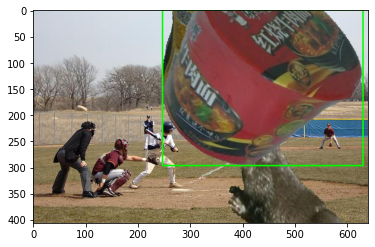

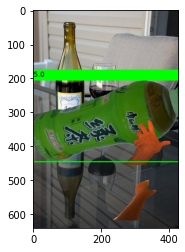

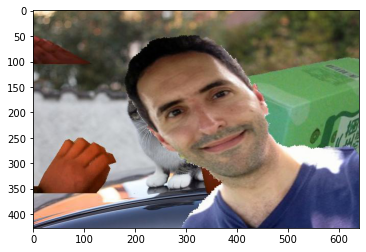

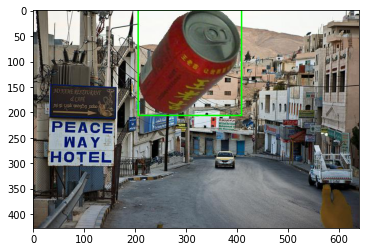

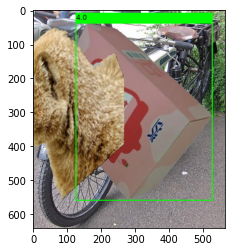

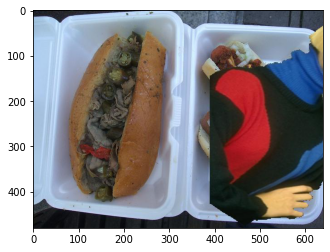

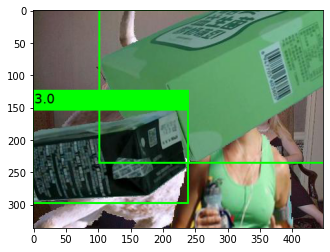

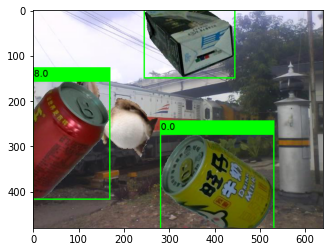

In [61]:
load_yolo = LoadYoLoImageFromDir(root_save_dir/'images')
display(load_yolo.path_df)
lbled_imgs = load_yolo.load(sample_n=8)
for img in lbled_imgs:
    img.show()

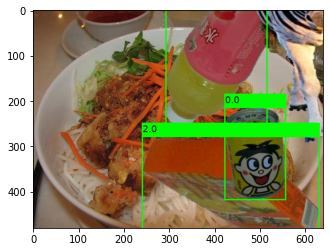